In [38]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.colors as mcolors
import plotly.express as px
from adjustText import adjust_text

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:

#plt.ion()

In [3]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize','seed','sigma'],
	'pso':['popsize', 'w','seed', 'c1', 'c2'],
	'bo-ucb':['seed','kappa'],
	'bo-ei': ['seed','xi'],
	'bo-poi': ['seed','xi']
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
['pso', 'cma', 'bo']


In [4]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

       progname probsize       xtime
0        bt_nas  lrgprob  745.260000
1        bt_nas  medprob   31.943333
2        bt_nas  smlprob    7.383333
3   cfd_rodinia  lrgprob    9.222637
4   cfd_rodinia  medprob    4.186460
5   cfd_rodinia  smlprob    1.578907
6        cg_nas  lrgprob  176.373333
7        cg_nas  medprob    4.796667
8        cg_nas  smlprob    1.143333
9        ft_nas  lrgprob  138.460000
10       ft_nas  medprob    3.903333
11       ft_nas  smlprob    0.940000
12         hpcg  lrgprob   65.220033
13         hpcg  medprob   17.178033
14         hpcg  smlprob    1.949250
15       lulesh  lrgprob   18.396099
16       lulesh  medprob    9.995197
17       lulesh  smlprob    4.854440


In [5]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'],
      dtype='object')
c1 [0.1  0.45 0.8  1.15 1.5   nan]
c2 [0.1  0.45 0.8  1.15 1.5   nan]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['pso' 'cma' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [18.  3. 21.  6. 24.  9. 27. 12. 30. 15. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [   nan  1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778
 30.   ]
w [0.1   0.325 0.55  0.775 1.      nan]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


In [6]:
def drawParetoPlot(*args, **kwargs):
	df = kwargs.pop('data').copy(deep=True)

	method = df['method'].iat[0]
	progname = df['progname'].iat[0]
	probsize = df['probsize'].iat[0]

	cols = hypers[method]
	#print('cols', cols)

	colsToKeep = cols+['globalSample', 'xtime']
	df = df[colsToKeep]

	df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

	#print('dropped cols')
	#print(df.head())

	# need to make one column with the cummax and grab the 300th step
	df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')

	#print('pre new index')
	#print(df.head())

	# rescale the xtime to be baseline-normalized
	df = df.set_index(cols)

	# do the baseline normalization here
	baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = baselineXtime/optimalXtime

	df['baselineXtime'] = baselineXtime/df['cummin']

	#print(f'{method} {progname} {probsize}')
	#print(df.head())

	# now make a new df with just the unique values of the hyperparam columns
	# the 'baselineXtime' column will be the max speedup we get after 300 steps
	#toplot = df[df['globalSample'] == 299.0]

	earliestSamples = pd.DataFrame(index=df.index.copy())
	earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
	earliestSamples['firstSample'] = 301
	earliestSamples['maxSpeedup'] = 0

	# now for each index, find the earliest globalSample that is greater than 1.0
	#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
	firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
	maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

	earliestSamples['firstSample'].update(firstSamp)
	earliestSamples['maxSpeedup'].update(maxSpeed)
	#earliestSamples = earliestSamples.reset_index()

	# drop the configurations that never reach the baseline
	#earliestSamples = earliestSamples.dropna(how='any')

	#print('earliestSamples')
	#print(earliestSamples.head())
	#print(earliestSamples.tail())


	#ax = plt.gca()
	
	ax = sns.scatterplot(earliestSamples, x='maxSpeedup', y='firstSample')

	ax.set_xlabel('Max Speedup after 300 steps')
	ax.set_ylabel('Earliest Timestep Surpassing Baseline Execution Time')
	ax.axvline(1.0, label='Baseline Speedup', zorder=0, c='red')
	ax.axvline(optimalXtime, label='Optimal Speedup', zorder=0, c='blue')
	#ax.legend()
	#ax.set_ylim(0, 302)
	#ax.set_xlim(0, optimalXtime+(0.02*optimalXtime))

	return

def makeParetoPlots(df, progname):
	#print(df.shape)
	#print(df.columns)

	df = df[df['progname'] == progname].reset_index(drop=True)

	#print(df.shape)
	#print(df.columns)

	g = sns.FacetGrid(df, row='method', col='probsize', col_order=probsizes, height=10, aspect=1.5, sharex=False, sharey=False)
	g.map_dataframe(drawParetoPlot, annot=True, xticklabels=True, yticklabels=True)
	
	for ax in g.axes.flatten():
		#ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
		ax.legend(loc='best')
	
	#plt.tight_layout()
	g.set_titles(col_template="Problem Size: {col_name}", row_template="GO Method: {row_name}")
	
	g.fig.subplots_adjust(top=0.96)
	g.fig.suptitle(f'GO Hyperparam Comparison ({progname.upper()})')
	
	plt.show()
	

	return

In [7]:
#makeParetoPlots(overallDF, 'bt_nas')
#makeParetoPlots(overallDF, 'ft_nas')
#makeParetoPlots(overallDF, 'hpcg')
#makeParetoPlots(overallDF, 'lulesh')

In [8]:
# now let's make the same plots in plotly


In [9]:
print(overallDF.columns)
print(overallDF.shape)

gomethods = list(hypers.keys())
print(gomethods)

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize',
       'progname', 'seed', 'sigma', 'w', 'xi', 'xtime'],
      dtype='object')
(20304000, 13)
['cma', 'pso', 'bo-ucb', 'bo-ei', 'bo-poi']


In [10]:
def tupleizeCols(df, cols):
	newColName = f'({",".join([str(col) for col in cols])})'
	df[newColName] = pd.Categorical(list(zip(*[df[col] for col in cols])))
	#df['code'] = df[newColName].cat.codes
	df = df.drop(cols, axis=1)
	return df, newColName

def fix_fig(fig, labels):
	fig.for_each_xaxis(lambda x: x.update(title = ''))
	fig.add_annotation(x=0.5,y=-0.2,
              text=labels['maxSpeedup'],
               xref="paper", yref="paper")
	fig.for_each_yaxis(lambda y: y.update(title = ''))
	fig.add_annotation(x=-0.05,y=0.5, 
              text=labels['firstSample'], textangle=-90,
               xref="paper", yref="paper")
	fig.show()
	return

In [11]:
def doPlotlyPlots(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)


			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']

			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()

			labels = {
				'firstSample': 'Earliest Timestep Surpassing Baseline Execution Time',
				'maxSpeedup': 'Max Speedup after 300 steps'
			}
			width = 900
			height = 400
			palette = 'BlueRed'
			#if method == 'pso':
			#	earliestSamples, newColName = tupleizeCols(earliestSamples, ['w', 'c1', 'c2'])
			#	newColName = 'code'
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='popsize', color=newColName, color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'cma':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
			#									 z='popsize', color='sigma', color_continuous_scale='Reds', #color_discrete_sequence=px.colors.sequential.Hot,
			#									 title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ei':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-poi':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='xi', title=f'{progname}-{probsize}-{method}', 
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)
			#elif method == 'bo-ucb':
			#	fig = px.scatter_3d(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
			#									 z='kappa', title=f'{progname}-{probsize}-{method}',
			#									 hover_data=list(earliestSamples.columns), width=900, height=500)

			if method == 'pso':
				#earliestSamples, newXCol = tupleizeCols(earliestSamples, ['popsize', 'w'])
				#earliestSamples, newYCol = tupleizeCols(earliestSamples, ['c1', 'c2'])

				#fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
				#								 facet_col=newXCol, facet_row=newYCol, #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
				#								 title=f'{progname}-{probsize}-{method}',
				#								 hover_data=list(earliestSamples.columns), width=1000, height=1000)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='popsize', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='w', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c1', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
				fix_fig(fig, labels)
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='c2', #color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'cma':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels, 
												 facet_col='popsize', color='sigma', color_continuous_scale=palette, #color_discrete_sequence=px.colors.sequential.Hot,
												 title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=500)
			elif method == 'bo-ei':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-poi':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='xi', title=f'{progname}-{probsize}-{method}', 
												 hover_data=list(earliestSamples.columns), width=width, height=height)
			elif method == 'bo-ucb':
				fig = px.scatter(earliestSamples, x='maxSpeedup', y='firstSample', labels=labels,
												 facet_col='kappa', title=f'{progname}-{probsize}-{method}',
												 hover_data=list(earliestSamples.columns), width=width, height=height)

			fix_fig(fig, labels)

In [12]:
#doPlotlyPlots(overallDF, 'bt_nas')
#doPlotlyPlots(overallDF, 'hpcg')
#doPlotlyPlots(overallDF, 'ft_nas')
#doPlotlyPlots(overallDF, 'lulesh')

In [50]:
# now let's take the top 10% of configurations 
# the criteria for selecting the top 10% is their euclidean distance
# of: (((300stepMaxSpeedup - optimalSpeedup)/optimalSpeedup)^2 + ((earliestTimestep-0)/299)^2)^(1/2)
# 

def plotTopPoints(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	for method in gomethods:
		top10s = pd.DataFrame()

		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

			# drop all the first samples, as they're random
			df = df[df['globalSample'] != 0.0 ]

			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']


			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()
			# now let's make the distance metric column
			#earliestSamples['score'] = (((earliestSamples['maxSpeedup'] - optimalXtime)/optimalXtime)**2 + (earliestSamples['firstSample']/299)**2)**(1/2)
			earliestSamples['score'] = earliestSamples['maxSpeedup']*0.5  + 0.5*(1/earliestSamples['firstSample'])

			# drop any samples with a score of exactly 0 -- meaning they found the
			# optimal on the first sample (i.e: a lucky sampling...)
			# earliestSamples = earliestSamples[earliestSamples.score != 0.0]

			# create a cutoff score, we keep scores smaller than this
			#cutoff_score = (((1-optimalXtime)/optimalXtime)**2 + (49/300)**2)**(1/2)

			#earliestSamples = earliestSamples[earliestSamples.score < cutoff_score]

			# now cut down on the samples and only show the top 10 configurations 
			earliestSamples = earliestSamples.sort_values(by=['score'], ascending=False)
			earliestSamples = earliestSamples.head(10)
			#top10perc = earliestSamples.shape[0]//10
			#earliestSamples = earliestSamples.head(top10perc)


			labels = {
				'firstSample': 'Earliest Timestep Surpassing Baseline Execution Time',
				'maxSpeedup': 'Max Speedup after 300 steps'
			}
			width = 900
			height = 400
			palette = 'BlueRed'

			#earliestSamples = earliestSamples.drop(['firstSample', 'maxSpeedup'], axis=1)
			
			for col in cols: #list(earliestSamples.columns) #cols:
				earliestSamples[col] = earliestSamples[col].astype('category')
				#ax = earliestSamples[col].value_counts().plot.bar(rot=0)
				#ax.set_title(f'{progname} {probsize} {method} {col}')
				#fig.axes.append(ax)

			earliestSamples['probsize'] = probsize

			top10s = pd.concat([top10s, earliestSamples], ignore_index=True)

			#melted = earliestSamples.melt(var_name='column')

			#if melted.shape[0] == 0:
			#	print(f'skipping {progname} {probsize} {method}')
			#	continue

			#g = sns.FacetGrid(melted, col='column', sharex=False, sharey=False)
			#g.map(plt.hist, 'value', align='mid', bins=10)
			#g.fig.subplots_adjust(top=0.8)
			#g.fig.suptitle(f'{progname} {probsize} {method}')

			#plt.show()
		
		# now take the top 10s and plot them
		print(f'{progname} {method} \n', top10s)

		def makeSubPlot(*args, **kwargs):
			data = kwargs.pop('data')

			data = data.drop(['firstSample', 'maxSpeedup'], axis=1)
			data.score = data.score.round(5)
			ax = sns.scatterplot(data, x=0, y='score')

			texts = []

			# for each datapoint, lets annotate
			for index, row in data.iterrows():
				annot = str(row.to_dict())
				#txt = plt.text(0,row.score, annot)
				#texts.append(txt)
				ax.annotate(annot, xy=(0, row['score']), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))

			#adjust_text(texts, [0]*(data.shape[0]), data.score, arrowprops=dict(arrowstyle='->', color='red'))
			return

		g = sns.FacetGrid(top10s, col='probsize', sharex=False, sharey=False, height=4, aspect=1.5)
		g.map_dataframe(makeSubPlot)

		g.fig.subplots_adjust(top=0.85)
		g.fig.suptitle(f'{progname} {method}')

		plt.show()

			
	return

bt_nas cma 
     popsize  seed   sigma  firstSample  maxSpeedup     score probsize
0       6.0  3827   4.222           17    1.008578  0.533701  smlprob
1      15.0  4873  30.000          115    1.008578  0.508637  smlprob
2      15.0  4873  26.778          115    1.008578  0.508637  smlprob
3      15.0  4873  23.556          115    1.008578  0.508637  smlprob
4      15.0  4873  20.333          115    1.008578  0.508637  smlprob
5      15.0  4873  17.111          115    1.008578  0.508637  smlprob
6      15.0  4873  13.889          115    1.008578  0.508637  smlprob
7      15.0  4873  10.667          115    1.008578  0.508637  smlprob
8      15.0  4873   7.444          115    1.008578  0.508637  smlprob
9      18.0  4873   4.222          130    1.008578  0.508135  smlprob
10      9.0  3827  23.556          300    1.000000  0.501667  medprob
11     27.0  4873  30.000          300    1.000000  0.501667  medprob
12     24.0  4873   4.222          300    1.000000  0.501667  medprob
13     

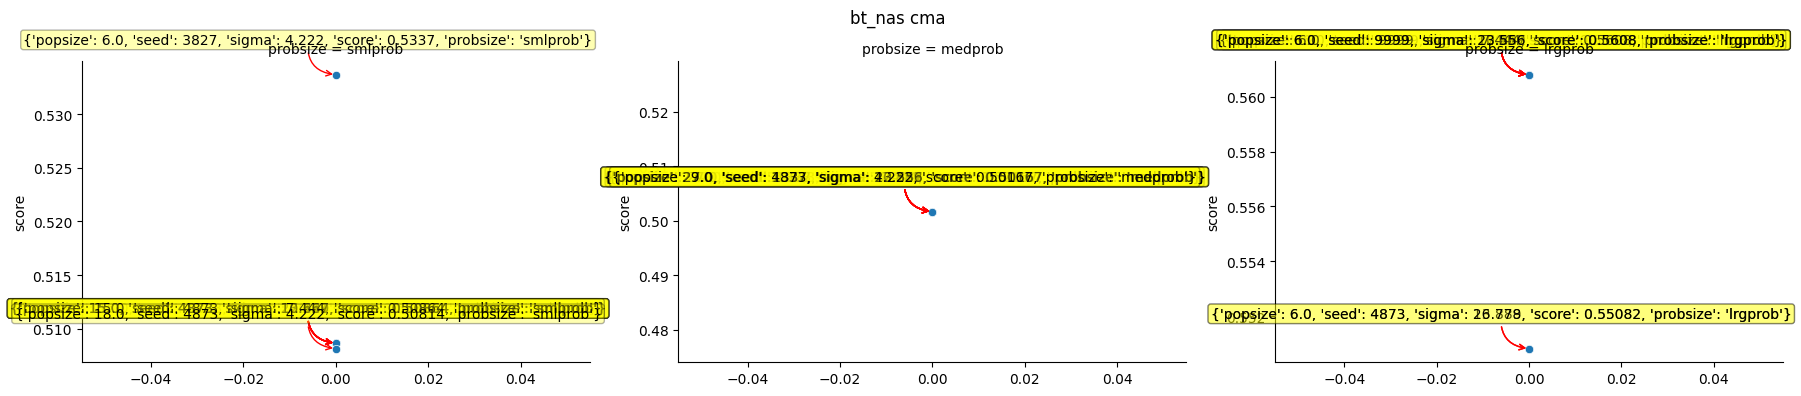

bt_nas pso 
     popsize      w  seed    c1    c2  firstSample  maxSpeedup     score probsize
0       3.0  1.000  9999  1.50  1.50            8    1.008578  0.566789  smlprob
1       3.0  0.775  9999  1.50  1.15            8    1.008578  0.566789  smlprob
2       3.0  0.775  9999  0.80  1.15            8    1.008578  0.566789  smlprob
3       3.0  0.775  9999  0.45  1.15            8    1.008578  0.566789  smlprob
4       3.0  0.775  9999  0.10  1.15            8    1.008578  0.566789  smlprob
5       3.0  1.000  9999  0.10  1.50            8    1.008578  0.566789  smlprob
6       3.0  0.550  9999  1.50  1.15            8    1.008578  0.566789  smlprob
7       3.0  1.000  9999  0.45  1.50            8    1.008578  0.566789  smlprob
8       3.0  0.550  9999  1.15  1.15            8    1.008578  0.566789  smlprob
9       3.0  0.550  9999  0.80  1.15            8    1.008578  0.566789  smlprob
10     15.0  0.325  4873  0.45  0.10          300    1.000000  0.501667  medprob
11      9.0  0.

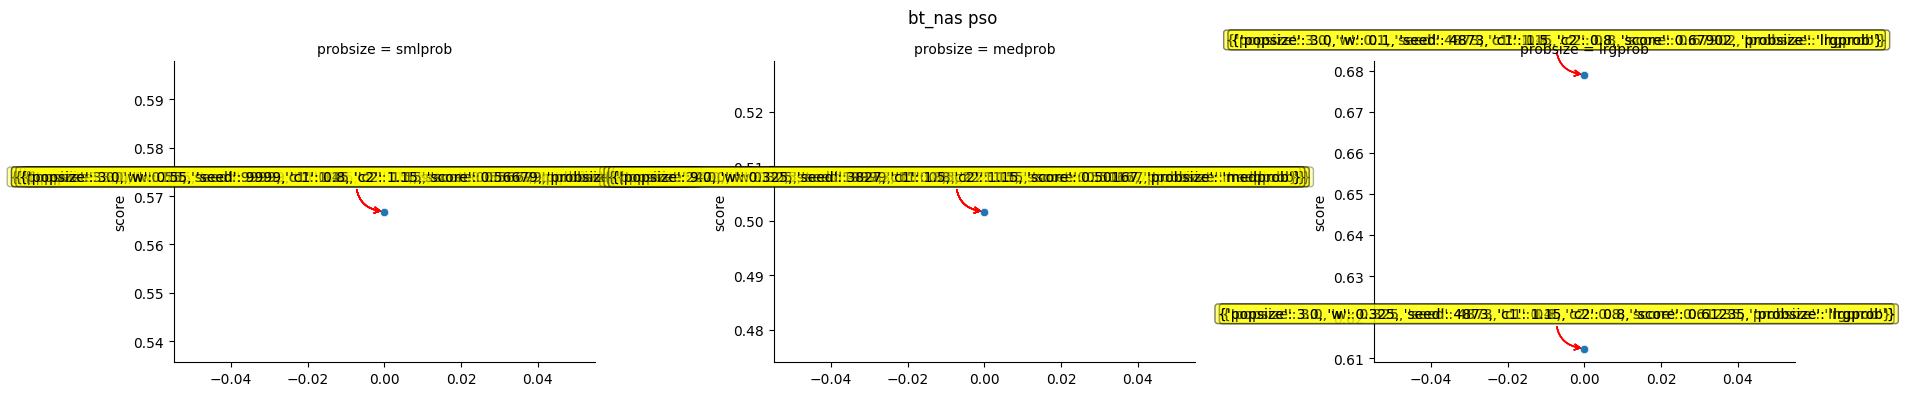

bt_nas bo-ucb 
     seed  kappa  firstSample  maxSpeedup     score probsize
0   1337   77.0            8    1.008578  0.566789  smlprob
1   1337  118.0            9    1.008578  0.559844  smlprob
2   1337  159.0            9    1.008578  0.559844  smlprob
3   1337  138.0            9    1.008578  0.559844  smlprob
4   1337  131.0            9    1.008578  0.559844  smlprob
5   1337  124.0            9    1.008578  0.559844  smlprob
6   1337  111.0            9    1.008578  0.559844  smlprob
7   1337  104.0            9    1.008578  0.559844  smlprob
8   1337   97.0            9    1.008578  0.559844  smlprob
9   1337   83.0            9    1.008578  0.559844  smlprob
10  4873    2.0          300    1.000000  0.501667  medprob
11  4873   83.0          300    1.000000  0.501667  medprob
12  3827   56.0          300    1.000000  0.501667  medprob
13  3827   83.0          300    1.000000  0.501667  medprob
14  3827  145.0          300    1.000000  0.501667  medprob
15  3827  165.0         

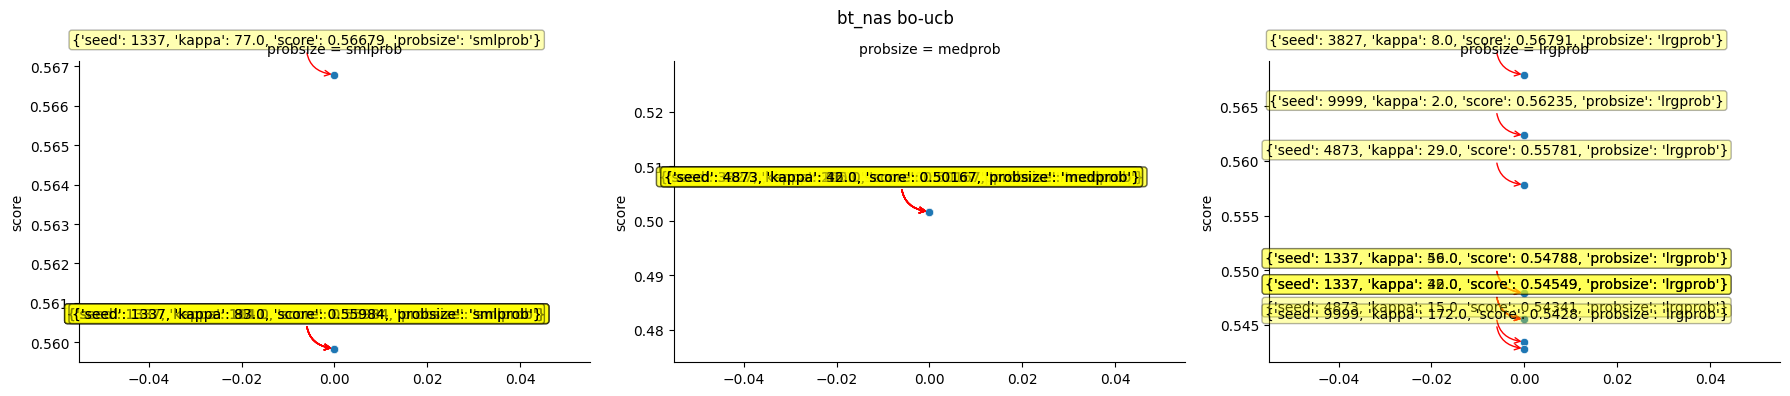

bt_nas bo-ei 
     seed     xi  firstSample  maxSpeedup     score probsize
0   3827  3.929            7    1.008578  0.575718  smlprob
1   3827  1.429           10    1.008578  0.554289  smlprob
2   4873  2.143           30    1.008578  0.520956  smlprob
3   1337  2.143           31    1.008578  0.520418  smlprob
4   1337  1.786           36    1.008578  0.518178  smlprob
5   4873  4.643           38    1.008578  0.517447  smlprob
6   3827  5.000           40    1.008578  0.516789  smlprob
7   1337  3.571           50    1.008578  0.514289  smlprob
8   1337  1.429           53    1.008578  0.513723  smlprob
9   1337  4.286           53    1.008578  0.513723  smlprob
10  1337  0.000          300    1.000000  0.501667  medprob
11  3827  5.000          300    1.000000  0.501667  medprob
12  4873  0.357          300    1.000000  0.501667  medprob
13  4873  0.714          300    1.000000  0.501667  medprob
14  4873  1.071          300    1.000000  0.501667  medprob
15  4873  1.429          

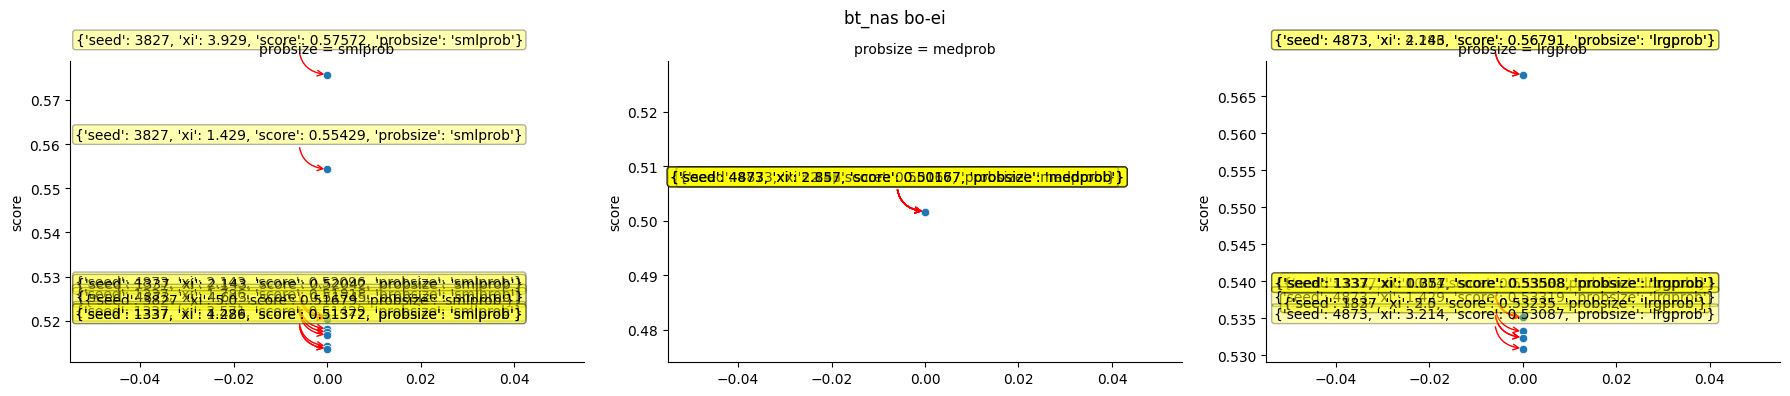

bt_nas bo-poi 
     seed     xi  firstSample  maxSpeedup     score probsize
0   3827  1.786            5    1.008578  0.604289  smlprob
1   3827  2.143            5    1.008578  0.604289  smlprob
2   3827  3.214            6    1.008578  0.587622  smlprob
3   3827  1.429           11    1.008578  0.549743  smlprob
4   3827  4.643           12    1.008578  0.545956  smlprob
5   3827  5.000           19    1.008578  0.530605  smlprob
6   3827  2.857           21    1.008578  0.528098  smlprob
7   3827  3.929           22    1.008578  0.527016  smlprob
8   1337  3.571           53    1.008578  0.513723  smlprob
9   1337  4.643           54    1.008578  0.513548  smlprob
10  9999  2.857          300    0.998645  0.500989  medprob
11  1337  3.929          300    0.998645  0.500989  medprob
12  4873  0.357          300    0.998437  0.500885  medprob
13  3827  0.357          300    0.998437  0.500885  medprob
14  4873  4.643          300    0.998437  0.500885  medprob
15  9999  5.000         

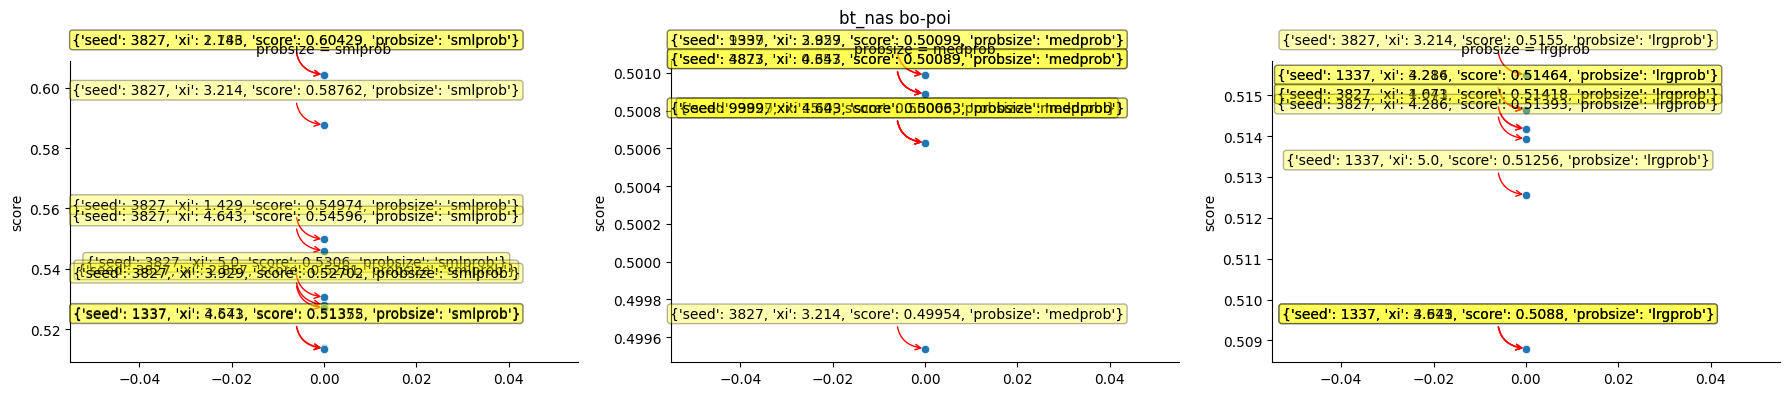

hpcg cma 
     popsize  seed   sigma  firstSample  maxSpeedup     score probsize
0      30.0  4873  30.000            1    1.083726  1.041863  smlprob
1       6.0  4873  26.778            1    1.083726  1.041863  smlprob
2       3.0  4873  23.556            1    1.083726  1.041863  smlprob
3       3.0  4873  26.778            1    1.083726  1.041863  smlprob
4       3.0  4873  30.000            1    1.083726  1.041863  smlprob
5      27.0  4873   4.222            1    1.083726  1.041863  smlprob
6       6.0  4873   7.444            1    1.083726  1.041863  smlprob
7       6.0  4873  10.667            1    1.083726  1.041863  smlprob
8       6.0  4873  13.889            1    1.083726  1.041863  smlprob
9       6.0  4873  17.111            1    1.083726  1.041863  smlprob
10     30.0  9999  30.000            1    1.199245  1.099622  medprob
11     12.0  9999  17.111            1    1.199245  1.099622  medprob
12     12.0  9999  23.556            1    1.199245  1.099622  medprob
13     12

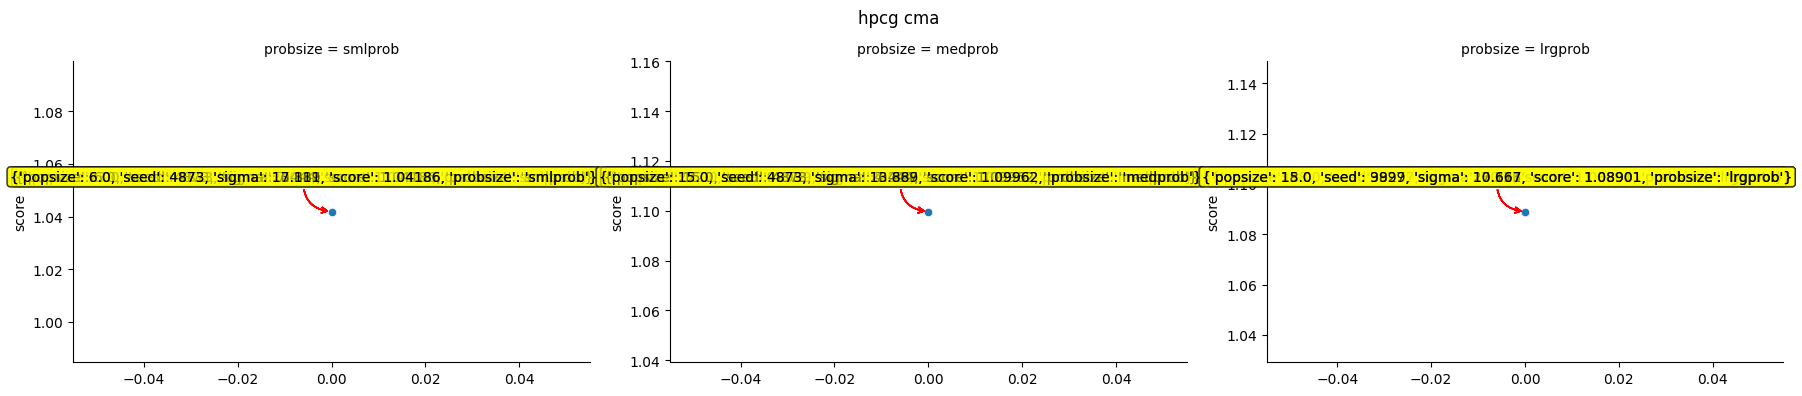

hpcg pso 
     popsize      w  seed    c1    c2  firstSample  maxSpeedup     score probsize
0       3.0  0.100  1337  0.10  0.10            1    1.083726  1.041863  smlprob
1       6.0  0.325  9999  1.15  1.15            1    1.083726  1.041863  smlprob
2      21.0  0.325  1337  1.50  1.50            1    1.083726  1.041863  smlprob
3      21.0  0.325  1337  1.15  1.50            1    1.083726  1.041863  smlprob
4      21.0  0.325  1337  1.15  0.45            1    1.083726  1.041863  smlprob
5      21.0  0.100  9999  1.50  1.15            1    1.083726  1.041863  smlprob
6       6.0  0.325  9999  0.80  0.45            1    1.083726  1.041863  smlprob
7       6.0  0.325  9999  0.80  1.15            1    1.083726  1.041863  smlprob
8       6.0  0.325  9999  0.80  1.50            1    1.083726  1.041863  smlprob
9       6.0  0.325  9999  1.15  0.45            1    1.083726  1.041863  smlprob
10     12.0  0.550  1337  1.15  1.50            1    1.199245  1.099622  medprob
11     18.0  1.00

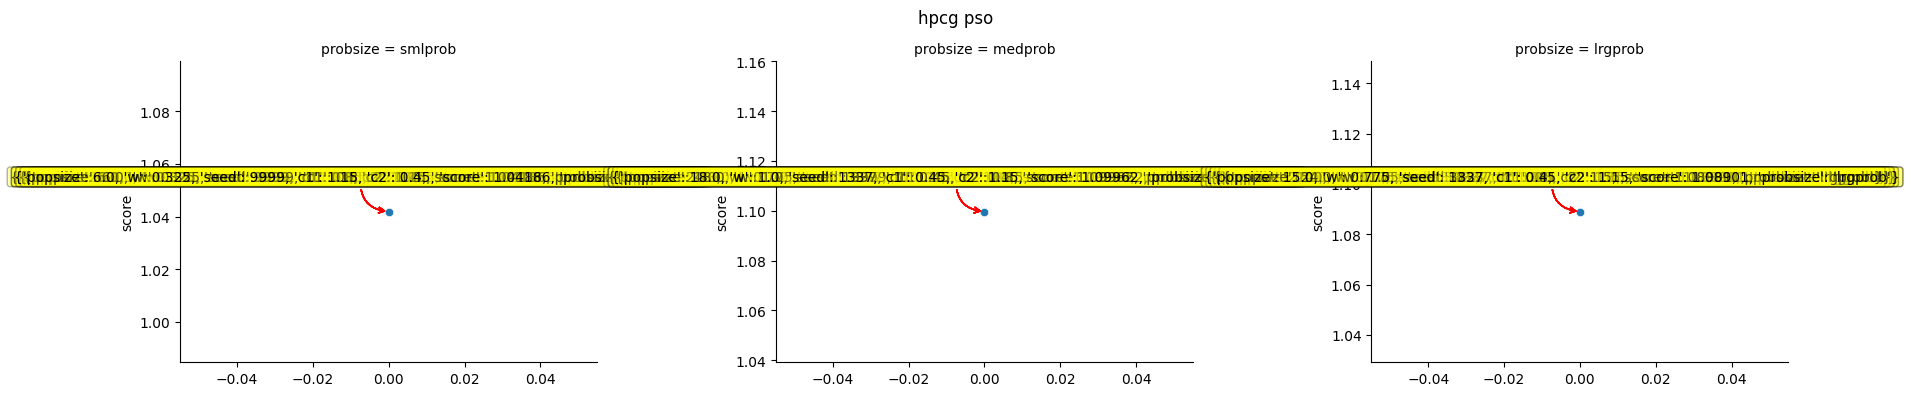

hpcg bo-ucb 
     seed  kappa  firstSample  maxSpeedup     score probsize
0   3827    8.0            3    1.083726  0.708530  smlprob
1   4873   36.0            3    1.083726  0.708530  smlprob
2   3827  200.0            3    1.083726  0.708530  smlprob
3   3827  193.0            3    1.083726  0.708530  smlprob
4   3827   22.0            3    1.083726  0.708530  smlprob
5   3827  159.0            3    1.083726  0.708530  smlprob
6   4873  179.0            3    1.083726  0.708530  smlprob
7   3827    2.0            3    1.083726  0.708530  smlprob
8   3827   56.0            3    1.083726  0.708530  smlprob
9   3827  104.0            3    1.083726  0.708530  smlprob
10  9999    2.0            1    1.199245  1.099622  medprob
11  4873    2.0            2    1.199245  0.849622  medprob
12  9999   90.0            2    1.199245  0.849622  medprob
13  4873   56.0            2    1.199245  0.849622  medprob
14  4873  131.0            2    1.199245  0.849622  medprob
15  4873  193.0           

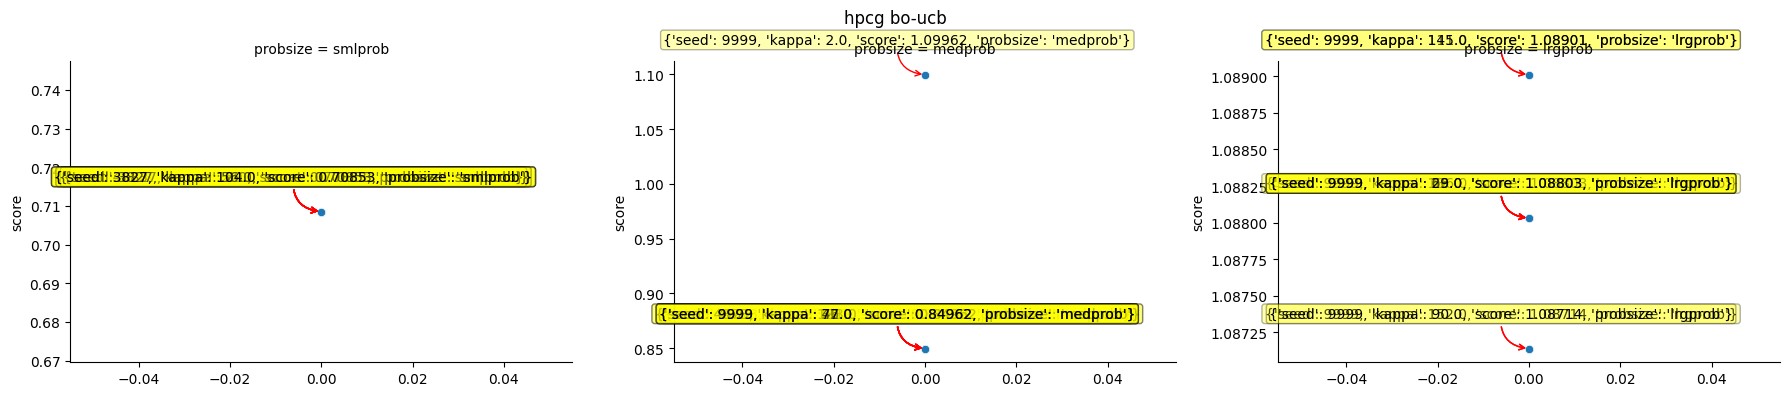

hpcg bo-ei 
     seed     xi  firstSample  maxSpeedup     score probsize
0   3827  4.643            3    1.083726  0.708530  smlprob
1   3827  2.857            3    1.083726  0.708530  smlprob
2   3827  0.357            3    1.083726  0.708530  smlprob
3   3827  1.429            3    1.083635  0.708484  smlprob
4   3827  1.071            3    1.083635  0.708484  smlprob
5   4873  4.643            3    1.083635  0.708484  smlprob
6   3827  0.714            3    1.083635  0.708484  smlprob
7   4873  1.071            3    1.083635  0.708484  smlprob
8   3827  0.000            3    1.083635  0.708484  smlprob
9   4873  5.000            3    1.081542  0.707438  smlprob
10  4873  3.929            1    1.199245  1.099622  medprob
11  9999  3.929            1    1.199245  1.099622  medprob
12  9999  2.143            1    1.199245  1.099622  medprob
13  9999  1.786            1    1.199245  1.099622  medprob
14  9999  1.429            1    1.199245  1.099622  medprob
15  4873  1.786            

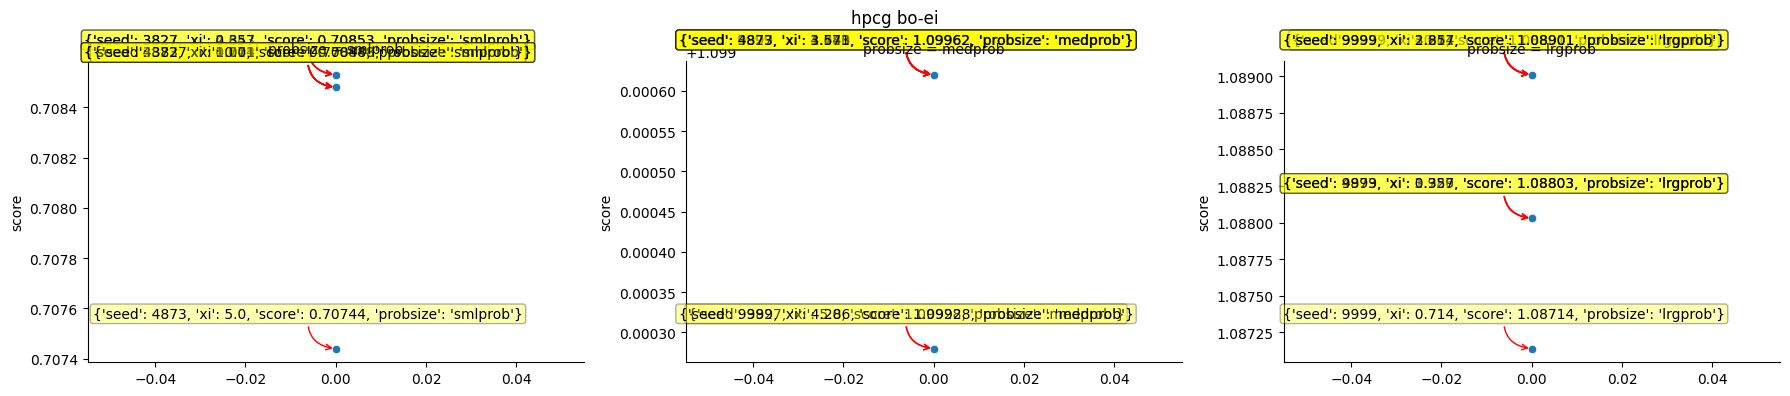

hpcg bo-poi 
     seed     xi  firstSample  maxSpeedup     score probsize
0   4873  0.000            1    1.058380  1.029190  smlprob
1   4873  1.786            3    1.083726  0.708530  smlprob
2   3827  5.000            3    1.083726  0.708530  smlprob
3   3827  0.357            3    1.083726  0.708530  smlprob
4   3827  3.571            3    1.083726  0.708530  smlprob
5   3827  1.071            3    1.083726  0.708530  smlprob
6   3827  2.500            3    1.083635  0.708484  smlprob
7   4873  1.071            3    1.083635  0.708484  smlprob
8   3827  4.643            3    1.083635  0.708484  smlprob
9   3827  1.429            3    1.083635  0.708484  smlprob
10  9999  0.714            1    1.199245  1.099622  medprob
11  9999  0.357            1    1.199245  1.099622  medprob
12  9999  1.071            1    1.199245  1.099622  medprob
13  9999  2.857            1    1.198556  1.099278  medprob
14  4873  0.000            1    1.181084  1.090542  medprob
15  9999  3.214           

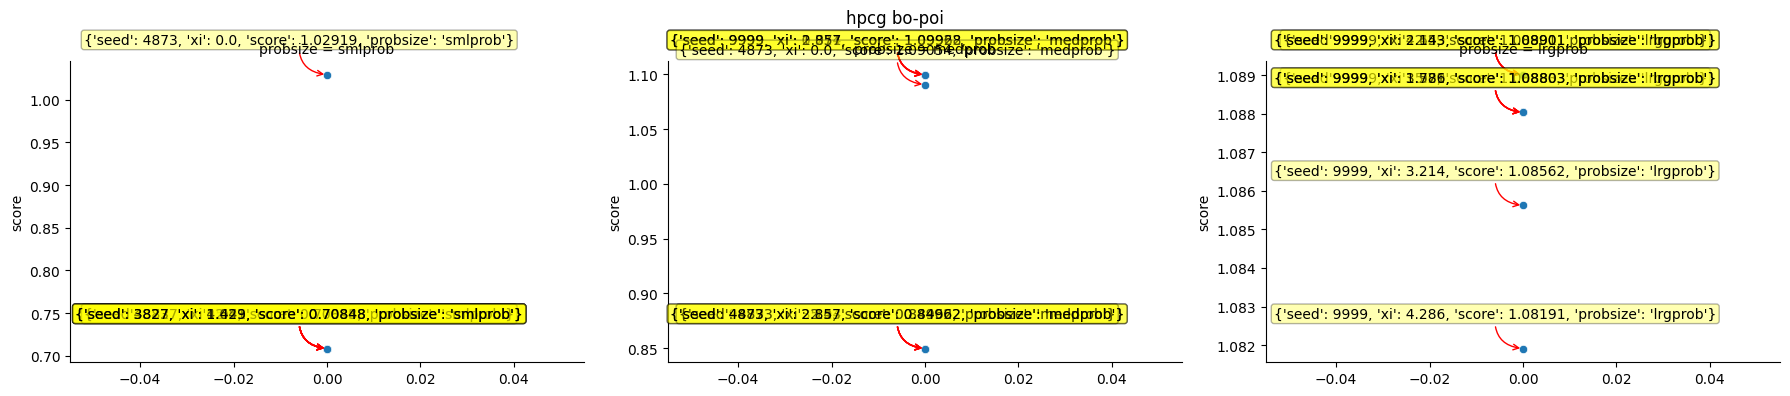

ft_nas cma 
     popsize  seed   sigma  firstSample  maxSpeedup     score probsize
0       6.0  3827   7.444           17    1.007092  0.532958  smlprob
1       6.0  3827  10.667           17    1.007092  0.532958  smlprob
2       6.0  3827  13.889           17    1.007092  0.532958  smlprob
3       6.0  3827  17.111           17    1.007092  0.532958  smlprob
4       6.0  3827  20.333           17    1.007092  0.532958  smlprob
5       6.0  3827  23.556           17    1.007092  0.532958  smlprob
6       6.0  3827  26.778           17    1.007092  0.532958  smlprob
7       6.0  3827  30.000           17    1.007092  0.532958  smlprob
8       3.0  1337   4.222           25    1.007092  0.523546  smlprob
9       9.0  4873   4.222           89    1.007092  0.509164  smlprob
10      6.0  3827  20.333           17    1.015371  0.537098  medprob
11      6.0  3827  17.111           17    1.015371  0.537098  medprob
12      6.0  3827   7.444           17    1.015371  0.537098  medprob
13     

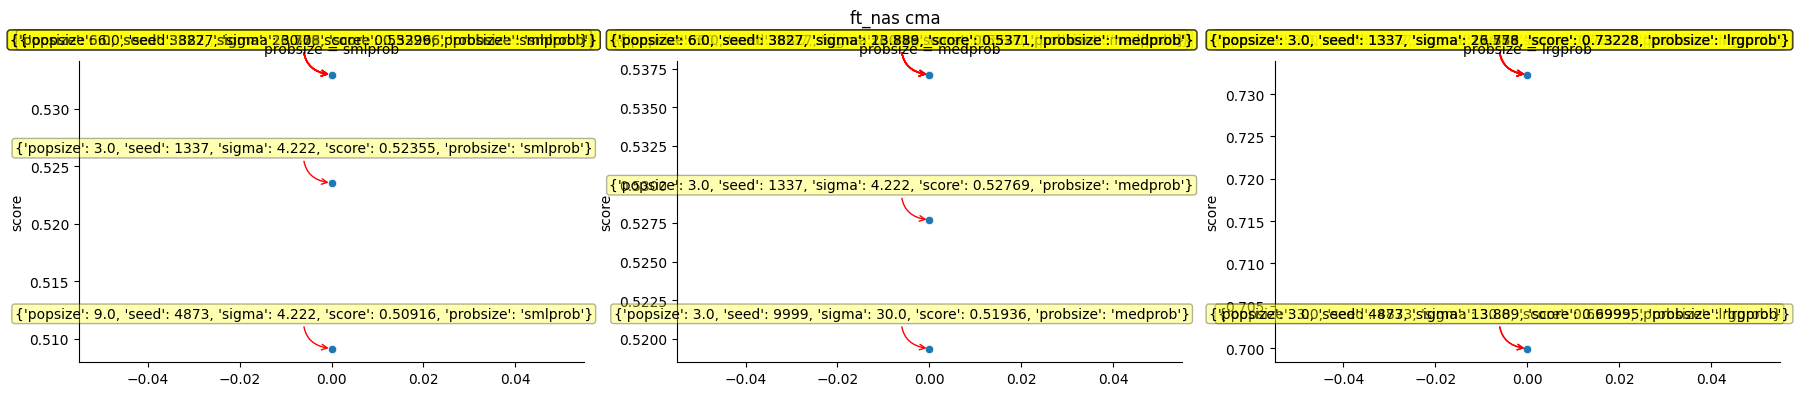

ft_nas pso 
    popsize      w  seed    c1    c2  firstSample  maxSpeedup     score probsize
0      3.0  0.100  4873  0.10  0.80            3    1.007092  0.670213  smlprob
1      3.0  0.100  4873  1.50  0.80            3    1.007092  0.670213  smlprob
2      3.0  0.100  4873  1.15  0.80            3    1.007092  0.670213  smlprob
3      3.0  0.100  4873  0.80  0.80            3    1.007092  0.670213  smlprob
4      3.0  0.100  4873  0.45  0.80            3    1.007092  0.670213  smlprob
5      3.0  0.325  4873  0.45  0.80            5    1.007092  0.603546  smlprob
6      3.0  0.325  4873  1.15  0.80            5    1.007092  0.603546  smlprob
7      3.0  0.325  4873  0.80  0.80            5    1.007092  0.603546  smlprob
8      3.0  0.325  4873  1.50  0.80            5    1.007092  0.603546  smlprob
9      3.0  0.325  4873  0.10  0.80            5    1.007092  0.603546  smlprob
10     3.0  0.100  4873  0.10  0.80            3    1.015371  0.674352  medprob
11     3.0  0.100  4873  1.

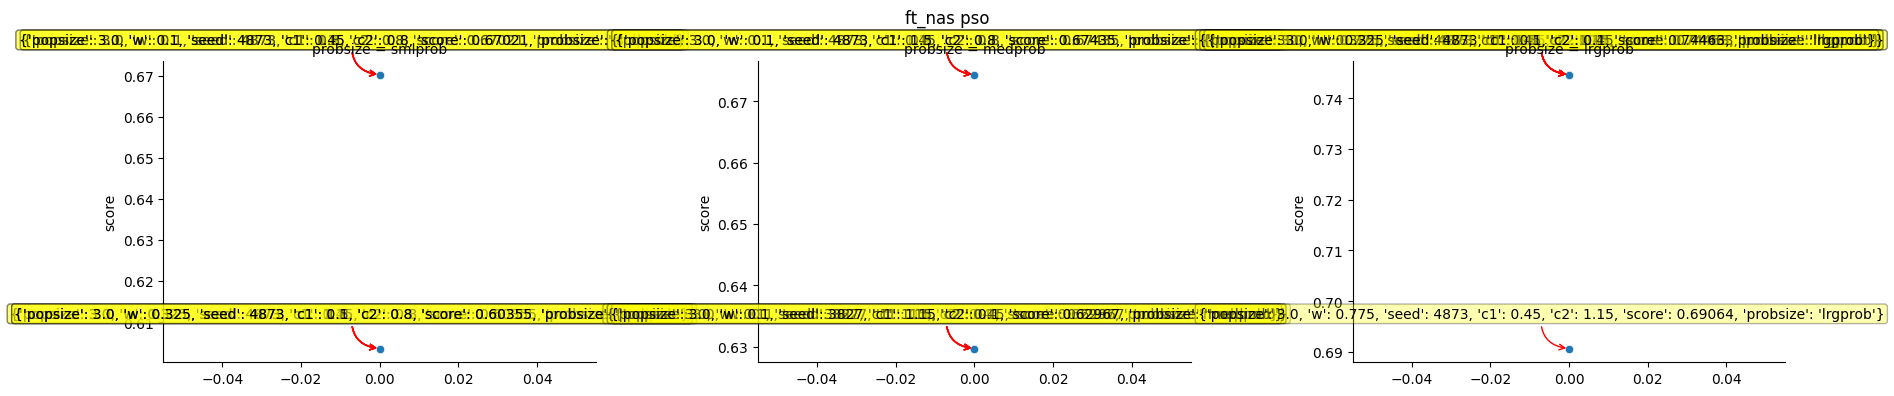

ft_nas bo-ucb 
     seed  kappa  firstSample  maxSpeedup     score probsize
0   3827  179.0           17    1.007092  0.532958  smlprob
1   3827  159.0           23    1.007092  0.525285  smlprob
2   4873   70.0           23    1.007092  0.525285  smlprob
3   3827    2.0           32    1.007092  0.519171  smlprob
4   9999   70.0           40    1.007092  0.516046  smlprob
5   4873    8.0           46    1.007092  0.514416  smlprob
6   4873   36.0           51    1.007092  0.513350  smlprob
7   3827   36.0           54    1.007092  0.512805  smlprob
8   1337   63.0           59    1.007092  0.512021  smlprob
9   1337    2.0           61    1.007092  0.511743  smlprob
10  4873   22.0           16    1.012777  0.537638  medprob
11  1337   29.0           30    1.015371  0.524352  medprob
12  3827  138.0           29    1.012777  0.523630  medprob
13  9999   15.0           35    1.015371  0.521971  medprob
14  1337   56.0           33    1.012777  0.521540  medprob
15  9999  104.0         

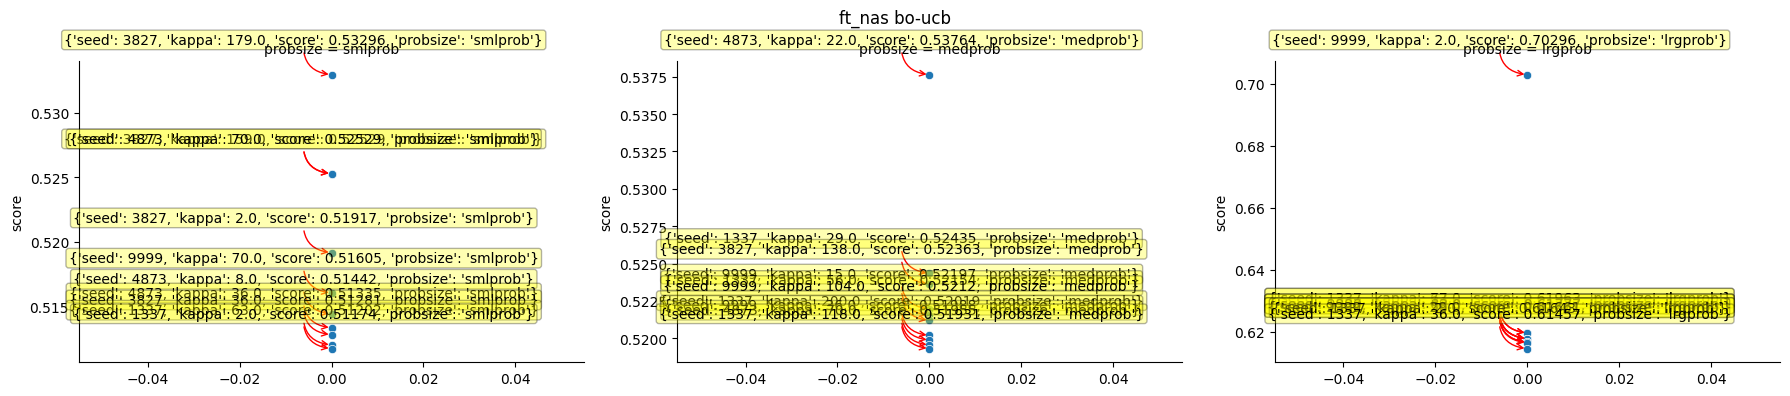

ft_nas bo-ei 
     seed     xi  firstSample  maxSpeedup     score probsize
0   4873  5.000           25    1.007092  0.523546  smlprob
1   3827  3.214           26    1.007092  0.522777  smlprob
2   1337  2.500           26    1.007092  0.522777  smlprob
3   3827  3.571           30    1.007092  0.520213  smlprob
4   4873  0.357           31    1.007092  0.519675  smlprob
5   3827  1.071           65    1.007092  0.511238  smlprob
6   1337  4.286           74    1.007092  0.510303  smlprob
7   1337  2.143           83    1.007092  0.509570  smlprob
8   9999  4.286           84    1.007092  0.509498  smlprob
9   4873  2.143           85    1.007092  0.509428  smlprob
10  4873  5.000           13    1.015371  0.546147  medprob
11  3827  1.786           17    1.012777  0.535800  medprob
12  4873  4.643           33    1.015371  0.522837  medprob
13  3827  0.357           36    1.015371  0.521575  medprob
14  3827  3.214           36    1.015371  0.521575  medprob
15  3827  2.500          

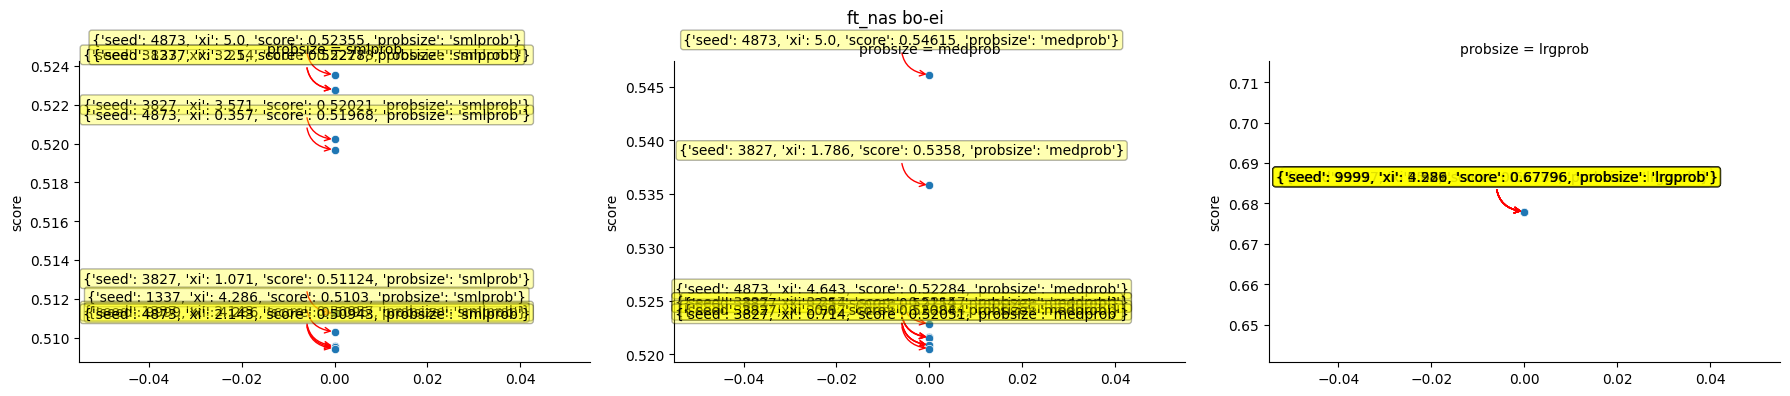

ft_nas bo-poi 
     seed     xi  firstSample  maxSpeedup     score probsize
0   3827  2.500           29    1.007092  0.520787  smlprob
1   3827  2.143           31    1.007092  0.519675  smlprob
2   3827  1.071           32    1.007092  0.519171  smlprob
3   3827  1.786           33    1.007092  0.518698  smlprob
4   9999  5.000           41    1.007092  0.515741  smlprob
5   1337  1.429           42    1.007092  0.515451  smlprob
6   1337  2.857           49    1.007092  0.513750  smlprob
7   3827  0.714           52    1.007092  0.513161  smlprob
8   3827  4.286           60    1.007092  0.511879  smlprob
9   1337  1.071           61    1.007092  0.511743  smlprob
10  3827  1.429           22    1.015371  0.530413  medprob
11  3827  4.643           50    1.015371  0.517686  medprob
12  3827  2.857           54    1.015371  0.516945  medprob
13  3827  5.000           48    1.012777  0.516805  medprob
14  3827  3.214           56    1.015371  0.516614  medprob
15  3827  3.929         

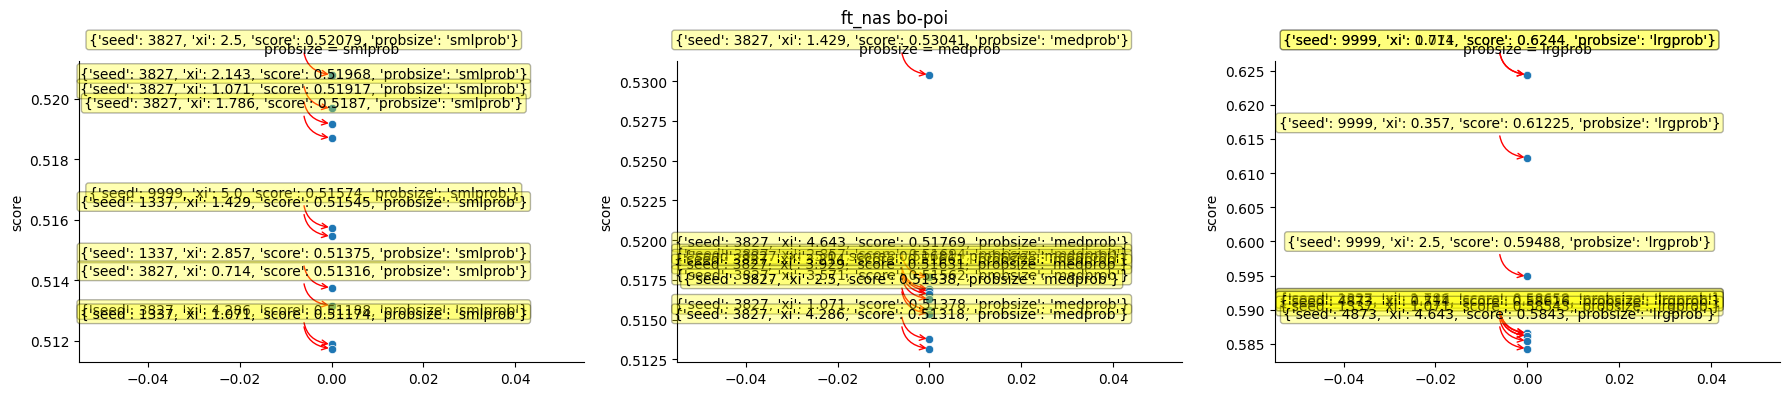

lulesh cma 
     popsize  seed   sigma  firstSample  maxSpeedup     score probsize
0      30.0  9999  30.000            1    4.383193  2.691597  smlprob
1      15.0  1337  30.000            1    4.383193  2.691597  smlprob
2      18.0  1337   7.444            1    4.383193  2.691597  smlprob
3      18.0  1337  10.667            1    4.383193  2.691597  smlprob
4      18.0  1337  13.889            1    4.383193  2.691597  smlprob
5      18.0  1337  17.111            1    4.383193  2.691597  smlprob
6      18.0  1337  20.333            1    4.383193  2.691597  smlprob
7      18.0  1337  23.556            1    4.383193  2.691597  smlprob
8      18.0  1337  26.778            1    4.383193  2.691597  smlprob
9      18.0  1337  30.000            1    4.383193  2.691597  smlprob
10      6.0  9999  30.000            1    2.493341  1.746670  medprob
11     24.0  1337  10.667            1    2.493341  1.746670  medprob
12     18.0  9999  26.778            1    2.493341  1.746670  medprob
13     

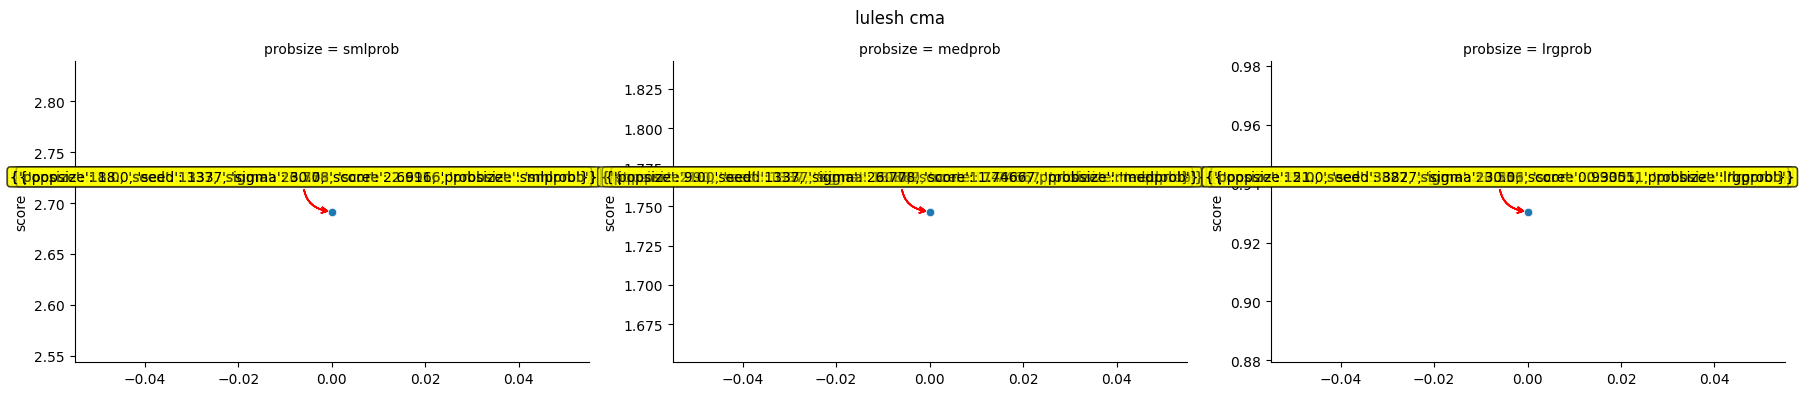

lulesh pso 
     popsize      w  seed    c1    c2  firstSample  maxSpeedup     score probsize
0      30.0  1.000  9999  1.50  1.50            1    4.383193  2.691597  smlprob
1      24.0  1.000  9999  1.15  0.80            1    4.383193  2.691597  smlprob
2      24.0  1.000  9999  1.15  1.50            1    4.383193  2.691597  smlprob
3      24.0  1.000  9999  1.50  0.45            1    4.383193  2.691597  smlprob
4      15.0  0.325  1337  0.10  0.45            1    4.383193  2.691597  smlprob
5      24.0  1.000  9999  1.50  1.15            1    4.383193  2.691597  smlprob
6      24.0  1.000  9999  1.50  1.50            1    4.383193  2.691597  smlprob
7      12.0  1.000  9999  1.50  1.50            1    4.383193  2.691597  smlprob
8      12.0  1.000  9999  1.50  1.15            1    4.383193  2.691597  smlprob
9      12.0  1.000  9999  1.50  0.80            1    4.383193  2.691597  smlprob
10     27.0  0.550  1337  1.15  0.80            1    2.493341  1.746670  medprob
11     18.0  0.

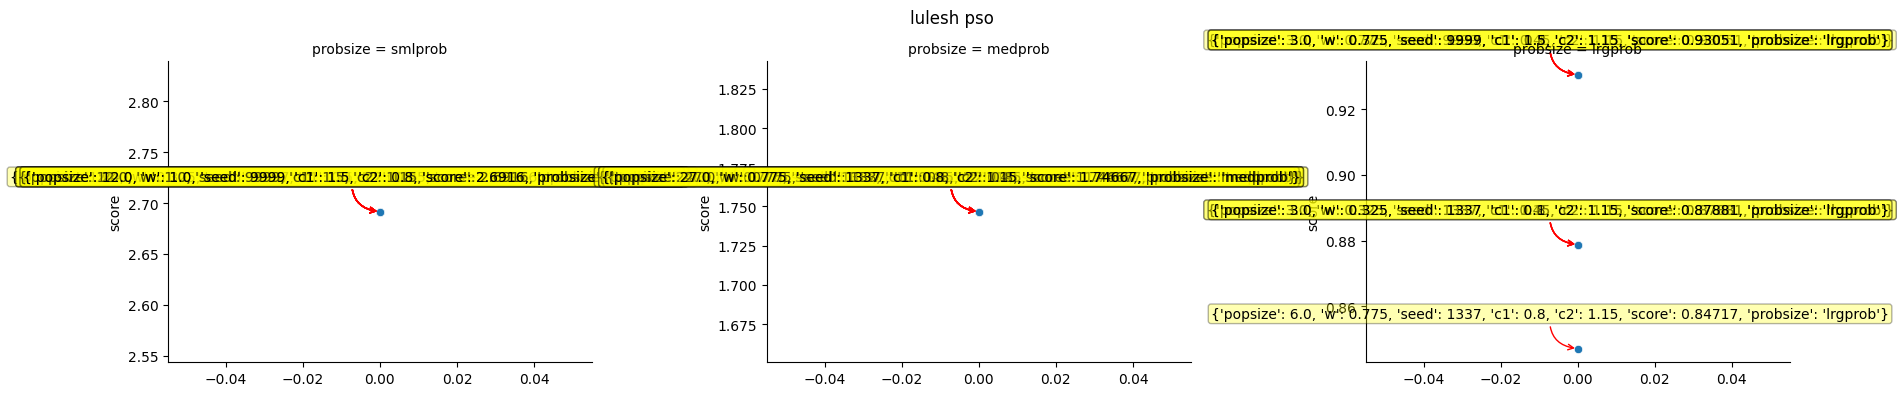

lulesh bo-ucb 
     seed  kappa  firstSample  maxSpeedup     score probsize
0   4873  193.0            1    4.383193  2.691597  smlprob
1   9999   36.0            1    4.383193  2.691597  smlprob
2   4873   15.0            1    4.383193  2.691597  smlprob
3   4873   22.0            1    4.383193  2.691597  smlprob
4   4873   29.0            1    4.383193  2.691597  smlprob
5   4873   63.0            1    4.383193  2.691597  smlprob
6   4873   97.0            1    4.383193  2.691597  smlprob
7   4873  159.0            1    4.383193  2.691597  smlprob
8   4873  172.0            1    4.383193  2.691597  smlprob
9   4873  186.0            1    4.383193  2.691597  smlprob
10  9999   22.0            1    2.493341  1.746670  medprob
11  9999  159.0            1    2.493341  1.746670  medprob
12  9999  138.0            1    2.493341  1.746670  medprob
13  9999  118.0            1    2.493341  1.746670  medprob
14  9999   15.0            1    2.405741  1.702871  medprob
15  9999  172.0         

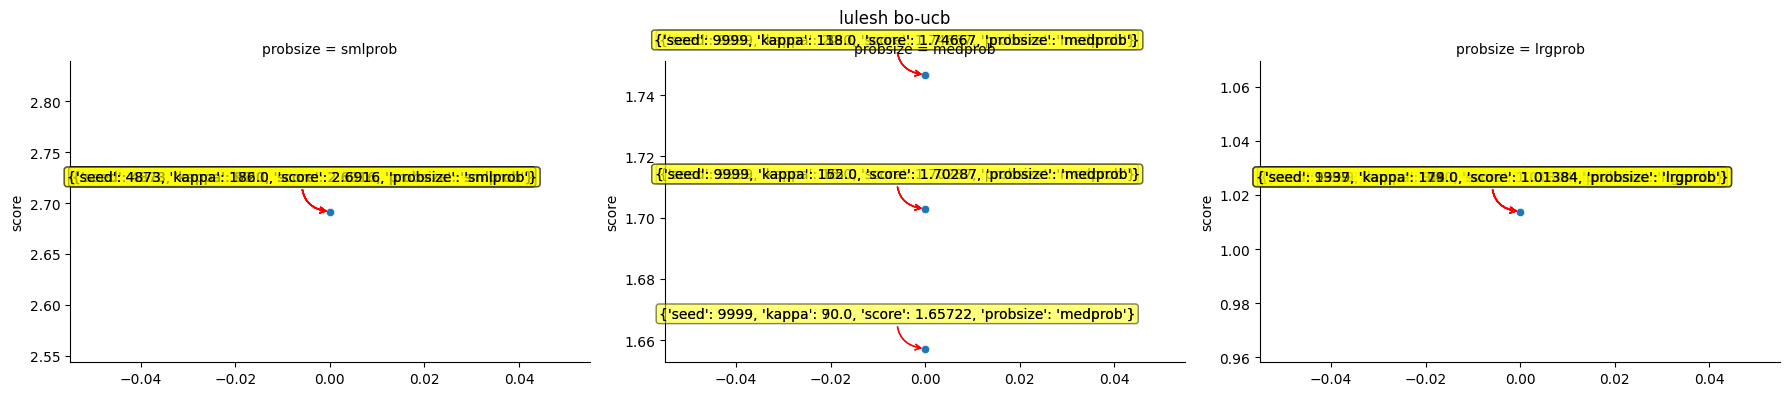

lulesh bo-ei 
     seed     xi  firstSample  maxSpeedup     score probsize
0   4873  0.000            1    4.383193  2.691597  smlprob
1   3827  1.429            1    4.383193  2.691597  smlprob
2   9999  4.643            1    4.383193  2.691597  smlprob
3   9999  3.214            1    4.383193  2.691597  smlprob
4   9999  2.500            1    4.383193  2.691597  smlprob
5   9999  1.071            1    4.383193  2.691597  smlprob
6   9999  0.714            1    4.383193  2.691597  smlprob
7   4873  3.571            1    4.383193  2.691597  smlprob
8   4873  3.214            1    4.383193  2.691597  smlprob
9   4873  1.429            1    4.383193  2.691597  smlprob
10  9999  0.000            1    2.493341  1.746670  medprob
11  9999  3.214            1    2.493341  1.746670  medprob
12  4873  3.571            1    2.405741  1.702871  medprob
13  9999  0.357            1    2.405741  1.702871  medprob
14  4873  3.929            1    2.314447  1.657224  medprob
15  9999  0.714          

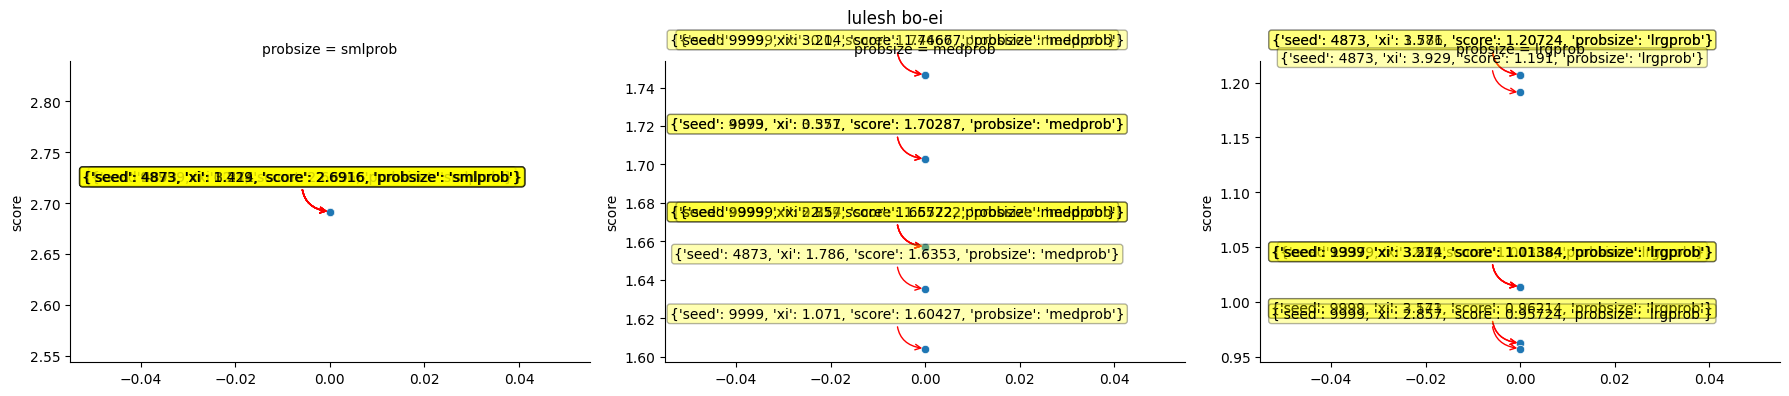

lulesh bo-poi 
     seed     xi  firstSample  maxSpeedup     score probsize
0   4873  0.000            1    4.383193  2.691597  smlprob
1   9999  2.500            1    4.383193  2.691597  smlprob
2   4873  1.786            1    4.383193  2.691597  smlprob
3   4873  2.143            1    4.383193  2.691597  smlprob
4   4873  2.500            1    4.383193  2.691597  smlprob
5   4873  2.857            1    4.383193  2.691597  smlprob
6   4873  3.214            1    4.383193  2.691597  smlprob
7   1337  0.357            1    4.383193  2.691597  smlprob
8   9999  3.214            1    4.383193  2.691597  smlprob
9   9999  3.571            1    4.383193  2.691597  smlprob
10  9999  1.786            1    2.493341  1.746670  medprob
11  9999  2.500            1    2.405741  1.702871  medprob
12  9999  4.286            1    2.405741  1.702871  medprob
13  9999  5.000            1    2.314447  1.657224  medprob
14  9999  4.643            1    2.314447  1.657224  medprob
15  9999  1.429         

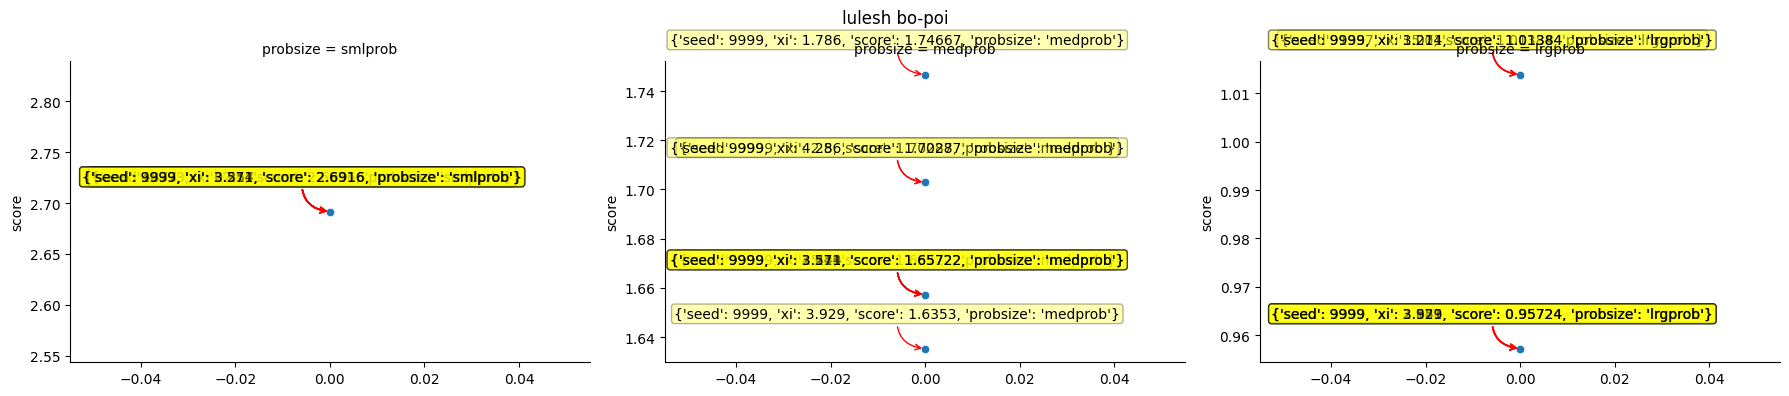

In [51]:
plotTopPoints(overallDF, 'bt_nas')
plotTopPoints(overallDF, 'hpcg')
plotTopPoints(overallDF, 'ft_nas')
plotTopPoints(overallDF, 'lulesh')

In [52]:
#fig = px.scatter(overallDF, x='globalSample', y='xtime', color='method', 
#					 facet_row='probsize', facet_col='progname')

#fig.show()